In [3]:
# import snap
import networkx as nx
import community
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import json

In [4]:
with open('shorter_edgelist.csv', 'rb') as file:
    Big = nx.read_weighted_edgelist(file, delimiter='~')

#### Node attribute (Which awards)

In [6]:
with open('node_attr1.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    node_attributes = defaultdict(dict)
    for row in reader:
        if int(row[1]) > 0:
            node_attributes[row[0]]['NIH'] = 1
        else:
            node_attributes[row[0]]['NIH'] = 0
        if int(row[2]) > 0:
            node_attributes[row[0]]['NSF'] = 1
        else:
            node_attributes[row[0]]['NSF'] = 0
        if int(row[3]) > 0:
            node_attributes[row[0]]['USDA'] = 1
        else:
            node_attributes[row[0]]['USDA'] = 0

In [7]:
with open('institution_attr1.csv', 'r') as file:
    reader = csv.reader(file, delimiter = ',')
    next(reader)
    univlist = set()
    for row in reader:
        univlist.add(int(row[1]))
    univ_table = {x:0 for x in univlist}
    
with open('institution_attr1.csv', 'r') as file:
    reader = csv.reader(file, delimiter = ',')
    next(reader)
    node_attributes2 = {}
    for row in reader:
        if row[0] not in node_attributes2:
            node_attributes2[row[0]] = univ_table.copy()
        node_attributes2[row[0]][int(row[1])] = 1

In [8]:
nx.set_node_attributes(Big, node_attributes)
nx.set_node_attributes(Big, node_attributes2)

In [9]:
BigLCC = Big.subgraph(max(nx.connected_components(Big), key=len))

In [10]:
print(nx.info(BigLCC))

Name: 
Type: Graph
Number of nodes: 44774
Number of edges: 1263365
Average degree:  56.4330


In [ ]:
b_average_clust = nx.average_clustering(BigLCC)
    
b_node = BigLCC.number_of_nodes()

b_cent = nx.degree(BigLCC)
b_maxcent = max([a[1] for a in b_cent])
b_freeman = sum([b_maxcent-a[1] for a in b_cent])/((BigLCC.number_of_nodes()-1)*(BigLCC.number_of_nodes()-2))

b_averagedeg = sum(dict(BigLCC.degree()).values())/b_node

#BigLCC total: Average degree, freeman, average clustering
BigLCC_describe = (b_averagedeg, b_freeman, b_average_clust)
#(56.43297449412606, 0.169296352950428, 0.7499335281452727)

In [ ]:
BigLCC_describe

In [32]:
ground_truth = {}

ground_truth['exclusive_nsf'] = list(filter(lambda x: (x[1]['NSF'] >= 1 and x[1]['NIH']==0 and x[1]['USDA']==0), BigLCC.nodes(data=True)))
ground_truth['exclusive_nih'] = list(filter(lambda x: (x[1]['NSF'] ==0 and x[1]['NIH']>= 1 and x[1]['USDA']==0), BigLCC.nodes(data=True)))
ground_truth['exclusive_usda'] = list(filter(lambda x: (x[1]['NSF']==0 and x[1]['NIH']==0 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))

ground_truth['combo_nsf_nih'] = list(filter(lambda x: (x[1]['NSF']>= 1 and x[1]['NIH']>= 1 and x[1]['USDA']== 0), BigLCC.nodes(data=True)))
ground_truth['combo_nsf_usda'] = list(filter(lambda x: (x[1]['NSF']>= 1 and x[1]['NIH']==0 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))
ground_truth['combo_nih_usda'] = list(filter(lambda x: (x[1]['NSF']==0 and x[1]['NIH']>= 1 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))

ground_truth['serve_all'] = list(filter(lambda x: (x[1]['NSF']>= 1 and x[1]['NIH']>= 1 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))
ground_truth['serve_other'] = list(filter(lambda x: (x[1]['NSF']==0 and x[1]['NIH']==0 and x[1]['USDA']== 0), BigLCC.nodes(data=True)))

ground_truth['serve_nsf'] = list(filter(lambda x: (x[1]['NSF'] >= 1), BigLCC.nodes(data=True)))
ground_truth['serve_nih'] = list(filter(lambda x: (x[1]['NIH']>= 1 ), BigLCC.nodes(data=True)))
ground_truth['serve_usda'] = list(filter(lambda x: (x[1]['USDA']>= 1), BigLCC.nodes(data=True)))

ground_truth['serve_nsf_nih'] = list(filter(lambda x: (x[1]['NSF']>= 1 and x[1]['NIH']>= 1 ), BigLCC.nodes(data=True)))
ground_truth['serve_nsf_usda'] = list(filter(lambda x: (x[1]['NSF']>= 1 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))
ground_truth['serve_nih_usda'] = list(filter(lambda x: (x[1]['NIH']>= 1 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))

In [33]:
ground_truth_single_attr = defaultdict(list)
list_of_node_attr = BigLCC.node[list(BigLCC.nodes())[0]].keys()

for attr in list_of_node_attr:
    for node in list(BigLCC.nodes()):
        if BigLCC.node[node][attr] >= 1:
            ground_truth_single_attr[attr].append(node)

### Louvain Modularity Community detection

In [46]:
partition = community.best_partition(BigLCC, randomize=False, random_state=15)
dend = community.generate_dendrogram(BigLCC)

In [64]:
with open('louvain_results.txt', 'w') as file:
    file.write(json.dumps(partition))

In [18]:
with open('louvain_results.txt', 'r') as file:
    partition = json.loads(file.read())

In [19]:
mostcom = Counter(partition.values())
len(mostcom.keys())

120

In [20]:
community.modularity(partition, BigLCC)

0.4912689254258832

In [21]:
mostcom.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119])

In [22]:
mostcom = Counter(partition.values()).most_common(15)
mostcom_communities = [x[0] for x in mostcom if x[1]>1000]

In [23]:
mostcom_communities

[8, 4, 1, 0, 3, 6, 7, 5, 15, 9]

In [25]:
[x for x in mostcom if x[1]>1000]

[(8, 7735),
 (4, 7560),
 (1, 5870),
 (0, 5564),
 (3, 4336),
 (6, 2822),
 (7, 1481),
 (5, 1218),
 (15, 1045),
 (9, 1015)]

In [29]:
community_dict = defaultdict(list)

for x in partition.keys():
    community_dict[partition[x]].append(x)

In [30]:
sum([len(community_dict[x]) for x in mostcom_communities])/44744

0.8637135705345969

In [34]:
## Compare each partition to ground_truth, to see if any are similar to ground
partition_max = {}

for truth in ground_truth.keys():
    print('Evaluating {}'.format(truth))
    true_community = set([x[0] for x in ground_truth[truth]])
    len_true = len(true_community)
    maxsame = 0
    
    for x in community_dict.keys():
        louvain_comm = set(community_dict[x])
        
        number_same = len(true_community.intersection(louvain_comm))
        if number_same > maxsame:
            maxsame = number_same
            partition_max[truth] = (x, number_same)
            frac = number_same/len_true
            print('New maximum found: Partition {}, with {} common nodes out of {} ({})'.format(x, number_same, len_true, frac))

Evaluating exclusive_nsf
New maximum found: Partition 0, with 670 common nodes out of 7460 (0.08981233243967829)
New maximum found: Partition 3, with 1099 common nodes out of 7460 (0.1473190348525469)
New maximum found: Partition 8, with 2128 common nodes out of 7460 (0.285254691689008)
Evaluating exclusive_nih
New maximum found: Partition 0, with 2373 common nodes out of 13132 (0.18070362473347548)
New maximum found: Partition 1, with 3006 common nodes out of 13132 (0.22890648796832166)
Evaluating exclusive_usda
New maximum found: Partition 0, with 43 common nodes out of 1728 (0.02488425925925926)
New maximum found: Partition 1, with 52 common nodes out of 1728 (0.03009259259259259)
New maximum found: Partition 2, with 122 common nodes out of 1728 (0.07060185185185185)
New maximum found: Partition 3, with 449 common nodes out of 1728 (0.25983796296296297)
Evaluating combo_nsf_nih
New maximum found: Partition 0, with 1372 common nodes out of 6309 (0.21746711047709621)
Evaluating combo_

In [36]:
node_attribute_by_cluster = defaultdict(dict)

for x in community_dict.keys():
    subgraph = BigLCC.subgraph(community_dict[x])
    tot_nodes = subgraph.number_of_nodes()
    
    for attr in list_of_node_attr:
        node_attribute_by_cluster[x][attr] = Counter(nx.get_node_attributes(subgraph, attr).values())
        nodes_w_attr = node_attribute_by_cluster[x][attr][1]
        node_attribute_by_cluster[x][attr] = (nodes_w_attr/tot_nodes, nodes_w_attr/len(ground_truth_single_attr[attr]))

In [37]:
partition_max

{'exclusive_nsf': (8, 2128),
 'exclusive_nih': (1, 3006),
 'exclusive_usda': (3, 449),
 'combo_nsf_nih': (0, 1372),
 'combo_nsf_usda': (8, 202),
 'combo_nih_usda': (4, 233),
 'serve_all': (4, 896),
 'serve_other': (8, 2875),
 'serve_nsf': (4, 3354),
 'serve_nih': (1, 4740),
 'serve_usda': (4, 1601),
 'serve_nsf_nih': (4, 2178),
 'serve_nsf_usda': (4, 1055),
 'serve_nih_usda': (4, 1129)}

In [38]:
# [8, 4, 1, 0, 3, 6, 7, 5, 15, 9]
node_attribute_by_cluster[6]

{'NIH': (0.6909992912827781, 0.08366944134557625),
 'NSF': (0.6247342310418144, 0.10078317041102156),
 'USDA': (0.1428065201984408, 0.06423334395919668),
 9730: (0.10595322466335932, 0.13709307657038056),
 45700: (0.1708008504606662, 0.11567074634029277),
 22165: (0.17753366406803686, 0.0844144903117102),
 14105: (0.18072289156626506, 0.16569200779727095),
 74915: (0.11587526576895818, 0.15202231520223153),
 10151: (0.08008504606661943, 0.12424409015942826),
 77480: (0.16335931963146705, 0.11606243705941591),
 10161: (0.1952515946137491, 0.09721242060691603),
 20150: (0.16335931963146705, 0.09264469453376206),
 12090: (0.24167257264351524, 0.11057068741893644),
 10171: (0.148830616583983, 0.12883435582822086),
 11584: (0.060240963855421686, 0.09518477043673013),
 27201: (0.1403260099220411, 0.04004449388209121),
 10181: (0.05350815024805103, 0.07291163689039111),
 27591: (0.04677533664068037, 0.14915254237288136),
 87501: (0.13855421686746988, 0.16271327507282562),
 10191: (0.057406094

In [39]:
bargraph = defaultdict(list)
bargraph2 = defaultdict(list)

for attr in list_of_node_attr:
    for community in mostcom_communities:
        bargraph[attr].append((community, node_attribute_by_cluster[community][attr][1]))
        bargraph2[attr].append((community, node_attribute_by_cluster[community][attr][0]))
    remainder = 1 - sum([x[1] for x in bargraph[attr]])
    bargraph[attr].append(('Smaller communities', remainder ))

In [40]:
[(k, *t) for k, v in bargraph.items() for t in v]
[(k, *t) for k, v in bargraph2.items() for t in v]

[('NIH', 8, 0.28002585649644474),
 ('NIH', 4, 0.5847883597883597),
 ('NIH', 1, 0.807495741056218),
 ('NIH', 0, 0.7451473759884975),
 ('NIH', 3, 0.2965867158671587),
 ('NIH', 6, 0.6909992912827781),
 ('NIH', 7, 0.49358541525995947),
 ('NIH', 5, 0.8456486042692939),
 ('NIH', 15, 0.5148325358851674),
 ('NIH', 9, 0.33399014778325126),
 ('NSF', 8, 0.3994828700711054),
 ('NSF', 4, 0.44365079365079363),
 ('NSF', 1, 0.33287904599659285),
 ('NSF', 0, 0.4311646297627606),
 ('NSF', 3, 0.4188191881918819),
 ('NSF', 6, 0.6247342310418144),
 ('NSF', 7, 0.27076299797434167),
 ('NSF', 5, 0.4072249589490969),
 ('NSF', 15, 0.23923444976076555),
 ('NSF', 9, 0.20591133004926107),
 ('USDA', 8, 0.12527472527472527),
 ('USDA', 4, 0.21177248677248678),
 ('USDA', 1, 0.14071550255536627),
 ('USDA', 0, 0.08411214953271028),
 ('USDA', 3, 0.2147140221402214),
 ('USDA', 6, 0.1428065201984408),
 ('USDA', 7, 0.05739365293720459),
 ('USDA', 5, 0.05829228243021346),
 ('USDA', 15, 0.0660287081339713),
 ('USDA', 9, 0.096

In [41]:
%matplotlib inline
testpd = pd.DataFrame([(*t, k) for k, v in bargraph.items() for t in v], columns = ['Community', 'Total', 'Agency'])

agency = testpd[testpd.Agency.isin(['USDA', 'NSF', 'NIH'])]
univ = testpd[testpd.Agency.isin(['USDA', 'NSF', 'NIH']) == False].rename(columns={'Agency':'University ID'})

In [52]:
percomm_pd = pd.DataFrame([(*t,k) for k, v in bargraph2.items() for t in v], columns = ['Community', 'Total', 'Agency'])
lista = percomm_pd[percomm_pd.Community == 8]
listb = lista[lista.Agency.isin(['USDA', 'NSF', 'NIH']) == False].rename(columns={'Agency':'University ID'})
listc = percomm_pd[percomm_pd.Agency.isin(['USDA', 'NSF', 'NIH']) == False].rename(columns={'Agency':'University ID'})

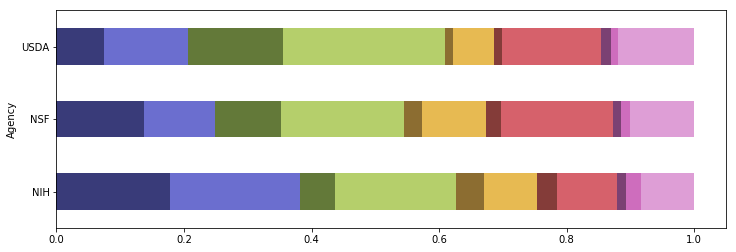

In [43]:
plota = agency.pivot(index = 'Agency', columns='Community').plot.barh(stacked=True, figsize=(12,4), colormap='tab20b', legend=False)
# plt.savefig('Top 10 Community representation in agencies.png')

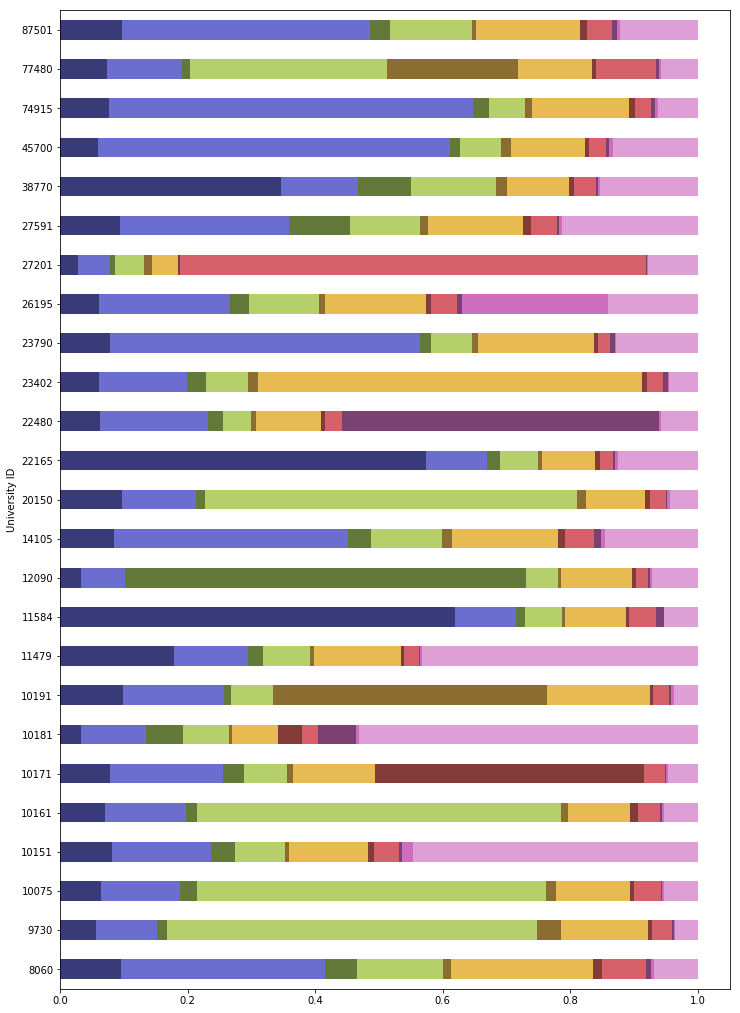

In [44]:
plotb = univ.pivot(index = 'University ID', columns='Community').plot.barh(stacked=True, figsize=(12,18), colormap='tab20b', legend=False)
# plt.savefig('Top 10 Community representation in universities.png')

Text(0,0.5,'% of nodes')

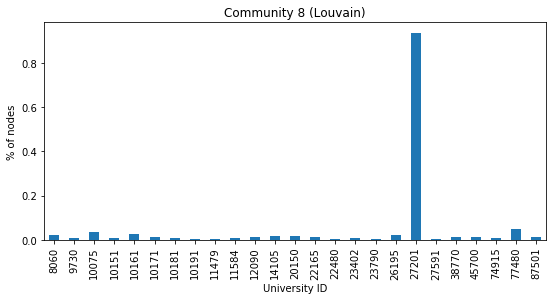

In [45]:
plotc =  listb.pivot(index = 'University ID', columns='Community').plot.bar(legend=False, figsize=(9,4), title='Community 8 (Louvain)')
plotc.set_ylabel('% of nodes')


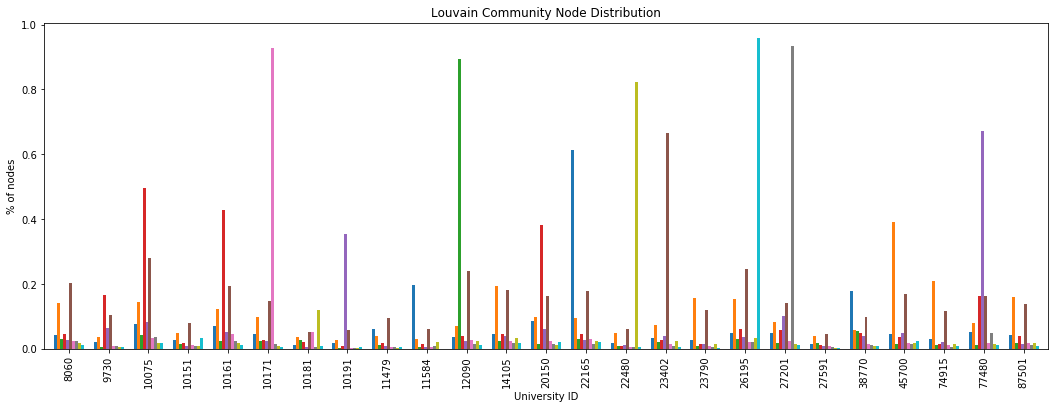

In [54]:
plotc =  listc.pivot(index = 'University ID', columns='Community').plot.bar(width=0.75, legend=False, figsize=(18,6), title='Louvain Community Node Distribution')
plotc.set_ylabel('% of nodes')
plt.savefig('Louvain community vs univ.png')

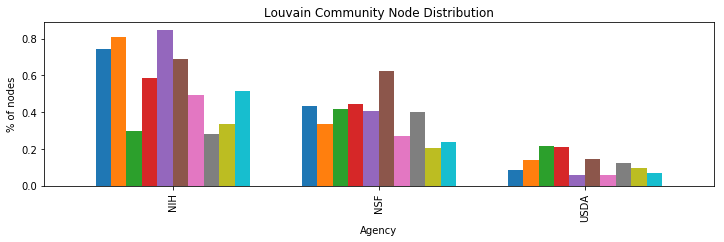

In [50]:
listd = percomm_pd[percomm_pd.Agency.isin(['USDA', 'NSF', 'NIH']) == True]
plotd =  listd.pivot(index = 'Agency', columns='Community').plot.bar(width=0.75, legend=False, figsize=(12,3), title='Louvain Community Node Distribution')
plotd.set_ylabel('% of nodes')
plt.savefig('Louvain community vs agency.png')

In [46]:
desc = {}

for x in mostcom_communities:
    subg = BigLCC.subgraph(community_dict[x])
    average_clust = nx.average_clustering(subg)
    
    node = subg.number_of_nodes()
    
    cent = nx.degree(subg)
    maxcent = max([a[1] for a in cent])
    freeman = sum([maxcent-a[1] for a in cent])/((subg.number_of_nodes()-1)*(subg.number_of_nodes()-2))
    
    averagedeg = sum(dict(subg.degree()).values())/node
    
    #Subgraph: Average degree, freeman, average clustering
    desc[x] = (node, averagedeg, freeman, average_clust)

In [47]:
import json
textf = json.dumps(desc)

with open('descriptive_louvain_comm.txt', 'w') as textfile:
    textfile.write(textf)

## Graph

In [ ]:
colors = zip(mostcom_communities, sns.color_palette('hls', len(mostcom_communities)))
# for x in set(partition.values()):
#     if x not in mostcom_communities:
#         colors.append((x, 'w'))
colors = dict(colors)

In [ ]:
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(BigLCC)

for com in set(partition.values()) :
    print(com)
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
nx.draw_networkx_edges(BigLCC, pos, alpha=0.5)
plt.axis('off')
plt.savefig('Louvain community detection.png')

In [ ]:
Copied = BigLCC.copy()
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    if com not in mostcom_communities:
        Copied.remove_nodes_from(list_nodes)

In [ ]:
print(nx.info(Copied))

In [ ]:
plt.figure(figsize=(20, 15))
ax = nx.spring_layout(Copied)

for com in mostcom_communities:
    print(com)
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(Copied, ax, list_nodes, node_size = 20, node_color = colors[com])
nx.draw_networkx_edges(Copied, ax, alpha=0.5)
plt.axis('off')
plt.savefig('Louvain community detection - top communities.png')

In [ ]:
plt.figure(figsize=(13, 9))
node_size = 25
count = 0
pos = nx.spring_layout(Copied)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

for com in communities.keys():
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    nx.draw_networkx_nodes(Copied, pos, list_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(Copied, pos, list([communities[com]]), node_size = node_size*5, node_color = colors[com])
nx.draw_networkx_edges(G_main_com, pos, alpha=0.5)
labels = {k: str(v) + ': ' + k for k,v in centers.items()}
nx.draw_networkx_labels(Copied, pos, labels)
plt.axis('off')
plt.show()